[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)

In [17]:

! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

## Other Computer Vision Problems: Key Points

This chapter explores two new computer vision problems beyond single-label classification:

* **Multi-label classification:** Predicting multiple labels (or none) for an image.
* **Regression:** Predicting a quantity (numerical value) as the label.

The chapter will delve deeper into:

* Output activations
* Targets
* Loss functions in deep learning models

### Multi-Label Classification

* Addresses the limitation of single-label classifiers where an image might not belong to any of the defined categories.
* Example: A bear classifier that could only predict grizzly, black, or teddy bear, even for non-bear images.
* Potential for wider applicability compared to single-label classifiers.

**Next Steps:**

* Explore multi-label dataset structure and preparation for models.
* Learn about adapting loss functions for multi-label classification (model architecture remains similar).


#### The Data
For our example we are going to use the PASCAL dataset, which can have more than one kind of classified object per image.

We begin by downloading and extracting the dataset as per usual:


In [18]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


This dataset is different from the ones we have seen before, in that it is not structured by filename or folder but instead comes with a CSV (comma-separated values) file telling us what labels to use for each image. We inspect the CSV file by reading it into a Pandas DataFrame above. As you can see, the list of categories in each image is shown as a space-delimited string.

## Pandas and DataFrames (.md)

**What is Pandas?**

* A Python library for data manipulation and analysis, especially for tabular and time series data.
* The main data structure is the DataFrame, representing a table with rows and columns.

**DataFrames: Creation and Access**

* You can create a DataFrame from various sources like CSV files, databases, or Python dictionaries.
* Access rows and columns using the `.iloc` property for matrix-like indexing:
    * `df.iloc[:, 0]` selects the first column.
    * `df.iloc[0, :]` selects the first row.

* Access columns by name directly:
    * `df['column_name']` selects a specific column.

**DataFrames: Manipulation**

* Create new columns using mathematical operations on existing columns.

**Learning Pandas**

* Pandas offers a powerful but potentially confusing API, so mastering it takes time.
* Utilize tutorials or books like "[Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do)" by Wes McKinney (creator of Pandas) to gain a deeper understanding.

In [19]:
print("Accessing 1st column: ", df.iloc[:,0])
print("Accessing 1st row: ", df.iloc[0,:]) # since trailing :, are always optional (in numpy, pytorch, pandas, etc.),
print("Accessing 1st row: ", df.iloc[0])
print("Accessing column by column name: ", df['fname'])

# Creating new df
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df



Accessing 1st column:  0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object
Accessing 1st row:  fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object
Accessing 1st row:  fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object
Accessing column by column name:  0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object


,a,b
0,1,3
1,2,4


In [20]:

# Adding columns in the new df
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


#### Constructing a DataBlock in fast.ai (.md)

This section explains how to use the fast.ai data block API to create a DataLoaders object from a DataFrame.

**Data Structures for Training and Validation**

* **PyTorch/fast.ai:**
    * **Dataset:** Represents a single data item (independent & dependent variables).
    * **DataLoader:** Iterator providing mini-batches of data items.
* **fast.ai:**
    * **Datasets:** Combines training and validation Datasets.
    * **DataLoaders:** Combines training and validation DataLoaders.

**Note:** DataLoaders build upon Datasets, adding mini-batching functionality. It's recommended to create and test Datasets first.

**Building a DataBlock Step-by-Step**

Fast.ai encourages an incremental approach to building a DataBlock:

1. **Gradual Construction:** Build the DataBlock step by step.
2. **Notebook Integration:** Use a notebook environment to verify data at each step.
3. **Debug Efficiency:** Easier to identify errors as they occur in the newly added code.


In [21]:
#Let’s start with the simplest case, which is a data block created with no parameters:
dblock = DataBlock()

#We can create a Datasets object from this. The only thing needed is a source—in this case, our DataFrame:
dsets = dblock.datasets(df)
     
#This contains a train and a valid dataset, which we can index into:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [22]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

As you can see, this simply returns a row of the DataFrame, twice. This is because by default, the data block assumes we have two things: input and target. We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing get_x and get_y functions:

In [23]:

x['fname']

'008663.jpg'

In [24]:

dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

As you can see, rather than defining a function in the usual way, we are using Python’s `lambda` keyword. This is just a shortcut for defining and then referring to a function. The following more verbose approach is identical:

In [25]:

def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [26]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002844.jpg', 'train')

- **Lambda Functions:**
  - Useful for quick iteration but incompatible with serialization.
  - Advisable to use verbose approach for exporting Learner after training.
  - Lambdas suitable for experimentation but not recommended for serialization.

- **Data Transformation:**
  - Independent variable conversion: Convert into complete path for image opening.
  - Dependent variable manipulation: Split on space character to create a list.
  - Default behavior of Python's split function splits on space character.

In [27]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]
     

(Path('/Users/wenda/.fastai/data/pascal_2007/train/002546.jpg'), ['dog'])

- To open the image and convert it into tensors, transforms are required; block types facilitate this process.
- Common block types can be utilized, but with an exception for `CategoryBlock`.
- `ImageBlock` remains suitable since a valid image path is provided.
- However, `CategoryBlock` is not suitable as it returns a single integer, whereas we require multiple labels for each item.
- To address this issue, we employ a `MultiCategoryBlock`.
- `MultiCategoryBlock` expects to receive a list of strings, which aligns with our current scenario.
- Testing the functionality of `MultiCategoryBlock` is essential in this context.

In [28]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]
     

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

- Categories are encoded differently from regular `CategoryBlock`.
  -  There we had a single integer representing which category was present, based on its location in our vocab.
- Here, in `MultiCategoryBlock`, there is Utilization of one-hot encoding: 
  - Represents categories using a list of zeros with a one indicating presence.
  - Each position with '1' signifies the presence of the corresponding category.
  - Allows encoding of categorical data efficiently.
- Reason for not using a list of category indices:
  - Lists would vary in length.
  - PyTorch requires tensors with consistent lengths.
- **One-hot Encoding:**
  - Definition: Utilizing a vector of zeros with '1' in positions representing data.
- Checking category representations using torch.where function:
  - Returns indices where a condition is true or false.

In [29]:

idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['bird']

- NumPy arrays, PyTorch tensors, and fastai's L class enable direct indexing using a list or vector, enhancing code clarity and conciseness.
- Ignoring the `is_valid` column defaults to a random split in DataBlock. To specify validation set elements explicitly, define a function for the "splitter" parameter, returning lists of integers representing train and validation indices.

In [30]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

- `DataLoader` collates `Dataset` items into mini-batches, forming a tuple of tensors.
- Each tensor stacks items from the respective location in the `Dataset` item.
- Confirming individual item validity is essential.
- Ensuring uniform size for all items is crucial for creating DataLoaders.
- `RandomResizedCrop` can be used to standardize item sizes.

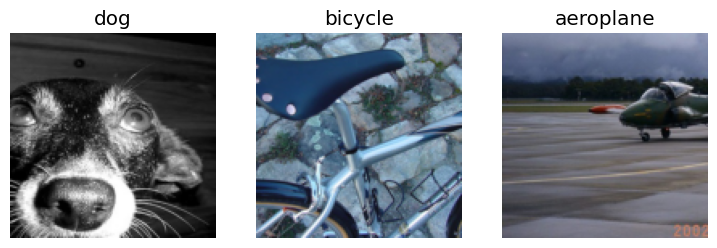

In [31]:

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

# And now we can display a sample of our data:
dls.show_batch(nrows=1, ncols=3)

- Use `summary` method for troubleshooting and understanding DataBlock functionality.
- Data is prepared for model training.
- Fastai library automatically selects binary cross-entropy loss function for classification tasks when creating a Learner.

### Binary Cross-Entropy Loss Function (for Image Classification)

This section discusses Binary Cross-Entropy loss function in the context of image classification using fast.ai.

* **Learner Object Components:**
    * Model Architecture
    * DataLoaders Object
    * Optimizer
    * Loss Function

* **Current Knowledge:**
    * DataLoaders are already defined.
    * We can use fast.ai's pre-built ResNet models (building them from scratch will be covered later).
    * Creating an SGD optimizer is known.

* **Focus:** Selecting an appropriate loss function.

- The model in a `Learner` is typically an object of a class inheriting from `nn.Module`.
- Calling the model using parentheses returns the activations of the model.
- To use the model, pass it the independent variable as a mini-batch.
- Experiment by fetching a mini-batch from the DataLoader and passing it to the model.


In [32]:

learn = vision_learner(dls, resnet18)

x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape
     

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/wenda/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.1MB/s]


torch.Size([64, 20])

Think about why activs has this shape—we have a batch size of 64, and we need to calculate the probability of each of 20 categories. Here’s what one of those activations looks like:

In [33]:
activs[0]

TensorImage([-1.1404, -3.3335, -0.6014,  2.4573, -4.3028, -2.8701, -1.1930,  1.1761, -0.4012, -4.9158, -2.8114,  0.1083,  2.7401, -3.2185,  2.3148, -0.0504, -1.4930,  3.3340,  1.3331,  0.6335],
            grad_fn=<AliasBackward0>)

**Getting Model Activations: A Debugging and Learning Tool**

**Importance:**

* Understanding model behavior through manual mini-batch processing and activation/loss observation is crucial for:
    * Debugging models.
    * Enhancing learning by visualizing the internal workings.

**Key Points:**

* Current activations haven't been normalized (scaled to 0-1), but the process using the sigmoid function was covered in previous notebooks.
* Loss calculation incorporates the concepts from previous notebooks with logarithmic transformation introduced in the previous chapter.


In [34]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

#### Working with One-Hot Encoded Labels in PyTorch

This section summarizes key points about handling one-hot encoded labels in PyTorch for multi-label classification:

**Loss Functions for One-Hot Encoded Labels:**

* **Not suitable:**
    * `softmax` (restricts sum of activations to 1, unsuitable for multiple labels).
    * `nll_loss` (designed for single labels, not multiple labels per item).

* **Suitable option:** `binary_cross_entropy` (efficiently handles multi-label scenario):
    * Performs element-wise comparison between predictions and targets for each label.

**Benefits of PyTorch's Broadcasting:**

* Allows writing code that works for both single items and batches without modifications.
* `binary_cross_entropy` exemplifies this by handling looping internally based on tensor rank.

**Available PyTorch Functions:**

* **For one-hot encoded targets:**
    * `F.binary_cross_entropy` (calculates cross-entropy without sigmoid)
    * **Recommended:** `F.binary_cross_entropy_with_logits` (performs both sigmoid and cross-entropy)
* **For single-label datasets:**
    * `F.nll_loss` (without softmax)
    * `F.cross_entropy` (with softmax)


In [36]:
# Since we have a one-hot-encoded target, we will use BCEWithLogitsLoss:

loss_func = nn.BCEWithLogitsLoss()
activs = torch.tensor(activs)  # Convert activs to torch.Tensor if it's not already
y = torch.tensor(y)  # Convert y to torch.Tensor if it's not already
loss = loss_func(activs, y)
loss

/var/folders/9z/1zsbrjl17xj_76sy78736hmr0000gn/T/ipykernel_70778/3090580518.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activs = torch.tensor(activs)  # Convert activs to torch.Tensor if it's not already
/var/folders/9z/1zsbrjl17xj_76sy78736hmr0000gn/T/ipykernel_70778/3090580518.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)  # Convert y to torch.Tensor if it's not already


tensor(1.0785)

**Multi-label Classification with fast.ai**

- **Loss Function**

  * fast.ai automatically selects the appropriate loss function based on the data.
  * For multi-label classification with multiple category labels, fast.ai uses `nn.BCEWithLogitsLoss` by default.

- **Metric for Multi-label Classification**
  ```py
  def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
    ```

  * `accuracy` metric is not suitable for multi-label problems because it assumes a single predicted class.
     * It compares the highest activation class with the target label.
  * In multi-label classification, an image can have multiple active classes.

- **Thresholding for Multi-label Classification**

  * Sigmoid activation is typically applied to outputs before interpreting them as probabilities (between 0 and 1).
  * A threshold is used to convert these probabilities into class labels (0 or 1).
     * Values above the threshold are considered class 1.
     * Values below the threshold are considered class 0.

- **Adjusting Threshold with `partial` Function**
  ```py
  def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
  ```

  * `accuracy_multi` function can be used to calculate accuracy with a specific threshold.
  * Python's `partial` function helps create a new version of a function with predefined arguments.
  * This allows creating a custom `accuracy_multi` metric with a desired default threshold value.


In [39]:
# For instance, here is a simple function taking two arguments:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')
     

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [40]:
#We can switch to a French version of that function by using partial:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [41]:
# We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/wenda/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.7MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.960920,0.712567,0.233685,03:52
1,0.836187,0.546740,0.294940,02:15
2,0.609664,0.197034,0.818406,02:05
3,0.359467,0.115722,0.948845,02:37


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126722,0.102946,0.951354,02:53
1,0.113303,0.094632,0.955119,02:30
2,0.096594,0.093664,0.956833,01:57


In [42]:
# Picking a threshold is important. 
# If you pick a threshold that's too low, you'll often be failing to select correctly labeled objects. 
# We can see this by changing our metric, and then calling validate, which returns the validation loss and metrics:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()
     

(#2) [0.0936644971370697,0.9385259747505188]

In [43]:
# If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()
     

(#2) [0.0936644971370697,0.9431672692298889]

In [44]:
# We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:
preds,targs = learn.get_preds()

In [ ]:
# Then we can call the metric directly. 
# # Note that by default get_preds applies the output activation function (sigmoid, in this case) for us, 
# #so we'll need to tell accuracy_multi to not apply it:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

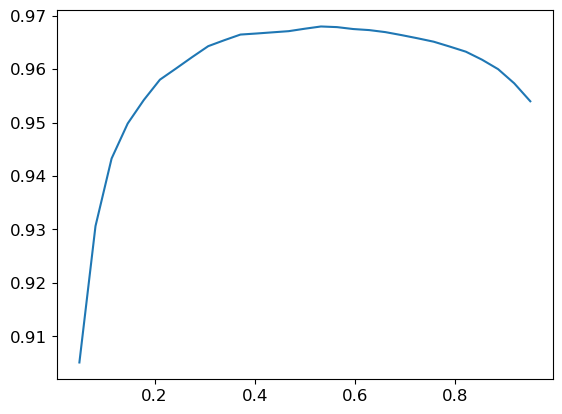

In [45]:
# We can now use this approach to find the best threshold level:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

#### Validation Set and Hyperparameter Tuning

* **Purpose of Validation Set:** Used to select hyperparameters (e.g., threshold in this case).

* **Overfitting Concerns:** Trying numerous hyperparameter values on the validation set can lead to overfitting.

* **Overfitting Mitigated:** In the above example, the smooth curve produced by changing the threshold suggests the model is not overfitting to the validation set. 

* **Key Point:**  Theory advises against using many hyperparameter values, but in practice, it might be acceptable for smooth relationships like this one.

Now, moving on to Regression Problems. 


### Image Regression with Fastai

**Rethinking Model Classification:**

* Traditionally, deep learning models are categorized by domains (computer vision, NLP, etc.).
* This section proposes a broader perspective based on variables and loss functions.

**Variety of Model Types:**

* This section emphasizes the vast possibilities beyond domain-specific models.
* Examples include:
    * Image input -> Text output (image caption generation).
    * Text input -> Image output (image generation from captions).
    * Combining images, text, and tabular data to predict outcomes (e.g., product purchases).

**Importance of Data Block API:**

* Understanding the data block API is crucial for creating custom solutions.
* This API allows flexibility in defining model inputs and outputs.

**Image Regression with Data Block API:**

* Image regression is a task where the independent variable is an image and the dependent variable is one or more floating-point numbers.
* The text demonstrates how to approach image regression using a CNN built on top of the data block API.

**Example: Key Point Detection**

* This section introduces a specific image regression task: key point detection.
* The goal is to predict the center of a person's face (represented by row and column coordinates) in an image.
